In [1]:
import os
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import numpy as np

from keras.datasets import cifar10, mnist
from keras.layers import (BatchNormalization, Conv2D, Conv2DTranspose, Dense,
                          Dropout, Flatten, Input, Reshape, UpSampling2D,
                          ZeroPadding2D)
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Model, Sequential
from keras.optimizers import Adam
from keras.utils.vis_utils import plot_model

%matplotlib inline



Using TensorFlow backend.


In [2]:
# Consistent results
np.random.seed(10)

# The dimension of z
noise_dim = 100

batch_size = 16
steps_per_epoch = 3750 # 60000 / 16
epochs = 21

save_path = './fcgan-images'

img_rows, img_cols, channels = 28, 28, 1

optimizer = Adam(0.0002, 0.5)

In [3]:
# Create path for saving images
if save_path != None and not os.path.isdir(save_path):
    os.mkdir(save_path)

#### example of loading the mnist dataset

In [4]:
# Load and pre-process data
(x_train, y_train), (x_test, y_test) = mnist.load_data()
# Normalize to between -1 and 1
x_train = (x_train.astype(np.float32) - 127.5) / 127.5

x_train = x_train.reshape(-1, img_rows*img_cols*channels)

In [5]:
print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 28, 28)


The example below plots the first 25 images from the training dataset in a 5 by 5 square.

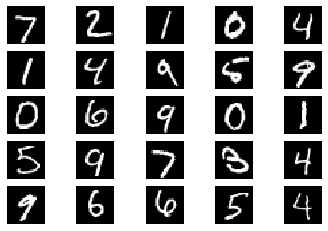

In [6]:
# plot images from the test dataset
for i in range(25):
	# define subplot
	plt.subplot(5, 5, 1 + i)
	# turn off axis
	plt.axis('off')
	# plot raw pixel data
	plt.imshow(x_test[i], cmap='gray')
plt.show()

In [7]:
def create_generator():
    generator = Sequential()
    
    generator.add(Dense(256, input_dim=noise_dim))
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(512))
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(1024))
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(img_rows*img_cols*channels, activation='tanh'))
    
    generator.compile(loss='binary_crossentropy', optimizer=optimizer)
    return generator

In [8]:
def create_descriminator():
    discriminator = Sequential()
     
    discriminator.add(Dense(1024, input_dim=img_rows*img_cols*channels))
    discriminator.add(LeakyReLU(0.2))

    discriminator.add(Dense(512))
    discriminator.add(LeakyReLU(0.2))

    discriminator.add(Dense(256))
    discriminator.add(LeakyReLU(0.2))

    discriminator.add(Dense(1, activation='sigmoid'))
    
    discriminator.compile(loss='binary_crossentropy', optimizer=optimizer)
    return discriminator

In [9]:
discriminator = create_descriminator()
generator = create_generator()


In [10]:
generator.summary()
plot_model(generator, to_file='generator.png', show_shapes=True, show_layer_names=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 256)               25856     
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 1024)              525312    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 1024)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 784)               803600    
Total para

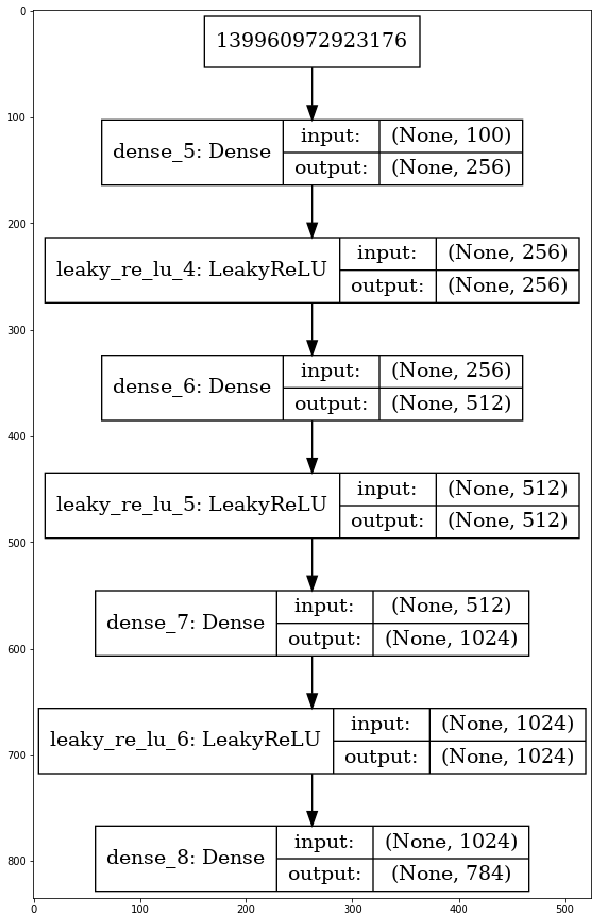

In [11]:
plt.figure(figsize=(10,20))
plt.imshow(plt.imread('./generator.png'))
plt.show()

In [12]:
discriminator.summary()
plot_model(discriminator, to_file='discriminator.png', show_shapes=True, show_layer_names=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1024)              803840    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               524800    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total para

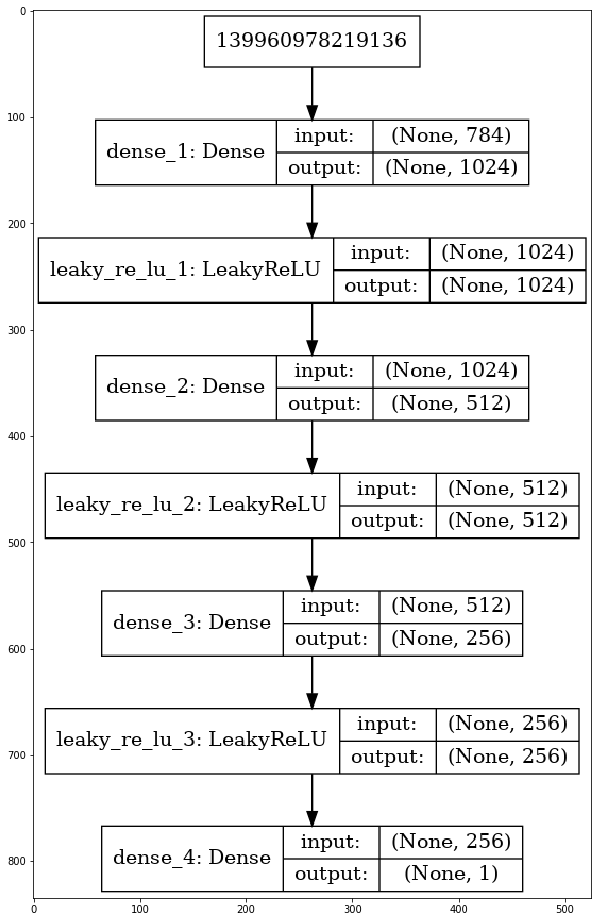

In [13]:
plt.figure(figsize=(10,20))
plt.imshow(plt.imread('./discriminator.png'))
plt.show()

In [14]:

# Make the discriminator untrainable when we are training the generator.  This doesn't effect the discriminator by itself
discriminator.trainable = False

# Link the two models to create the GAN
gan_input = Input(shape=(noise_dim,))
fake_image = generator(gan_input)

gan_output = discriminator(fake_image)

gan = Model(gan_input, gan_output)
gan.compile(loss='binary_crossentropy', optimizer=optimizer)

In [15]:
# Display images, and save them if the epoch number is specified
def show_images(noise, epoch=None):
    generated_images = generator.predict(noise)
    plt.figure(figsize=(10, 10))
    
    for i, image in enumerate(generated_images):
        plt.subplot(10, 10, i+1)
        if channels == 1:
            plt.imshow(image.reshape((img_rows, img_cols)), cmap='gray')
        else:
            plt.imshow(image.reshape((img_rows, img_cols, channels)))
        plt.axis('off')
    
    plt.tight_layout()
    
    if epoch != None and save_path != None:
        plt.savefig(f'{save_path}/gan-images_epoch-{epoch}.png')
    plt.show()

Epoch: 0 	 Discriminator Loss: 0.5194641351699829 		 Generator Loss: 1.8438720703125


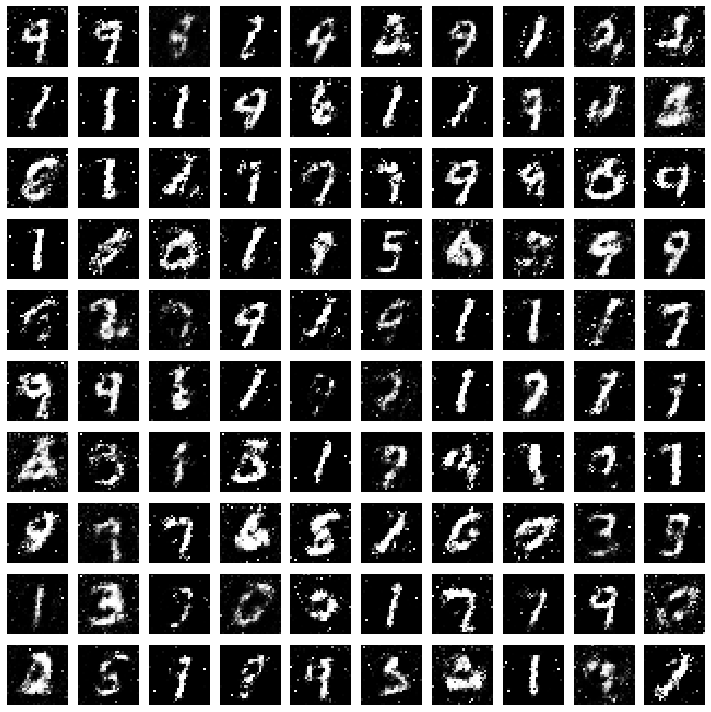

Epoch: 1 	 Discriminator Loss: 0.539303183555603 		 Generator Loss: 1.524958848953247
Epoch: 2 	 Discriminator Loss: 0.6105819940567017 		 Generator Loss: 1.337564468383789
Epoch: 3 	 Discriminator Loss: 0.5571581721305847 		 Generator Loss: 1.661299705505371
Epoch: 4 	 Discriminator Loss: 0.6591085195541382 		 Generator Loss: 1.535193681716919
Epoch: 5 	 Discriminator Loss: 0.5519201159477234 		 Generator Loss: 1.6001129150390625
Epoch: 6 	 Discriminator Loss: 0.47885602712631226 		 Generator Loss: 1.605825424194336
Epoch: 7 	 Discriminator Loss: 0.5698919296264648 		 Generator Loss: 1.4600087404251099
Epoch: 8 	 Discriminator Loss: 0.631402313709259 		 Generator Loss: 1.5586309432983398
Epoch: 9 	 Discriminator Loss: 0.6201595067977905 		 Generator Loss: 1.6810142993927002
Epoch: 10 	 Discriminator Loss: 0.537116289138794 		 Generator Loss: 1.8433864116668701


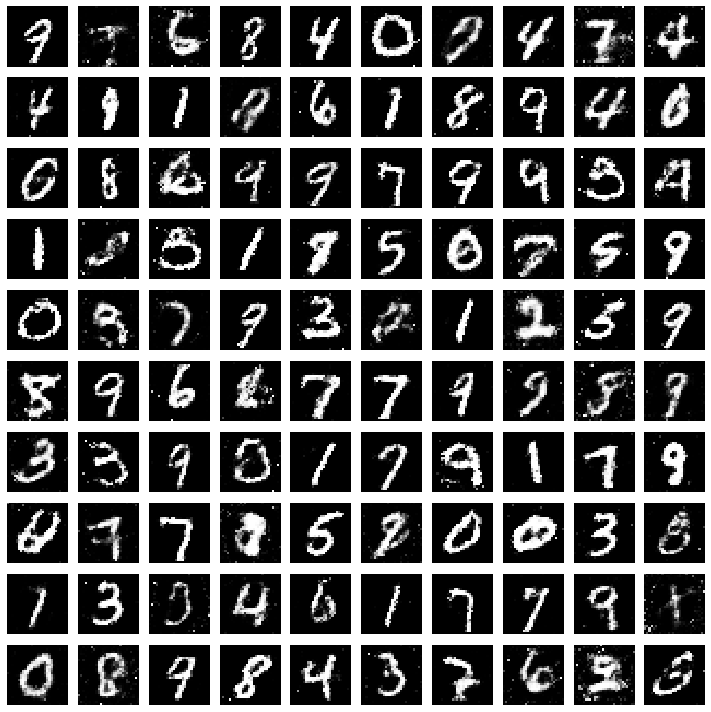

Epoch: 11 	 Discriminator Loss: 0.6766047477722168 		 Generator Loss: 1.3221681118011475
Epoch: 12 	 Discriminator Loss: 0.5907244682312012 		 Generator Loss: 1.4152195453643799
Epoch: 13 	 Discriminator Loss: 0.6006640195846558 		 Generator Loss: 1.2055944204330444
Epoch: 14 	 Discriminator Loss: 0.5846157073974609 		 Generator Loss: 1.3701759576797485
Epoch: 15 	 Discriminator Loss: 0.6139200329780579 		 Generator Loss: 1.3670833110809326
Epoch: 16 	 Discriminator Loss: 0.48410284519195557 		 Generator Loss: 1.970133900642395
Epoch: 17 	 Discriminator Loss: 0.6527124643325806 		 Generator Loss: 1.476393222808838


In [ ]:
# Constant noise for viewing how the GAN progresses
static_noise = np.random.normal(0, 1, size=(100, noise_dim))

for epoch in range(epochs):
    for batch in range(steps_per_epoch):
        noise = np.random.normal(0, 1, size=(batch_size, noise_dim))
        fake_x = generator.predict(noise)

        real_x = x_train[np.random.randint(0, x_train.shape[0], size=batch_size)]
        
        x = np.concatenate((real_x, fake_x))

        disc_y = np.zeros(2*batch_size)
        disc_y[:batch_size] = 0.9

        d_loss = discriminator.train_on_batch(x, disc_y)

        y_gen = np.ones(batch_size)
        g_loss = gan.train_on_batch(noise, y_gen)

    print(f'Epoch: {epoch} \t Discriminator Loss: {d_loss} \t\t Generator Loss: {g_loss}')
    if epoch % 10 == 0:
        show_images(static_noise, epoch)
# save the generator model tile file
filename = './weight_file/generator_model_%03d.h5' % (epoch + 1)
generator.save(filename)